### Import packages

In [4]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from bayes_opt import BayesianOptimization

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [6]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [7]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [8]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [9]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [10]:
df = target_transform(df)

In [11]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [12]:
from feature_engineering import CategoricalColumnsEncoder

In [13]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Prepare kfolds

In [14]:
n_folds = 3
feat_engs = []
df_trains = []
df_vals = []
folds = KFold(n_splits=n_folds, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]

    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    feat_engs.append(feat_eng)
    df_trains.append(df_train)
    df_vals.append(df_val)

### Early stop

In [15]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
              'lambda_l2': 0.1,
             }

In [16]:
def kfold_cv_early_stop(**params_update):
    #params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    lgb_other_params = {'num_boost_round': 20000,
                        'verbose_eval': 2000,
                        'early_stopping_rounds': 1000,
                       }
    
    print('==', params, '==')
    
    scores = []
    scores2 = []
    es_iter = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = mean_squared_log_error(df_val['total_price'], y_pred_final)
        score2 = cal_score(df_val['total_price'], y_pred_final)
        
        scores.append(score)
        scores2.append(score2)
        es_iter.append(model.best_iteration)
    
    result = [np.mean(scores), scores, np.mean(scores2), scores2, np.mean(es_iter), es_iter]
    print(result)    
    return result

In [17]:
kfold_cv_early_stop()

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00876275
[4000]	valid_0's mape: 0.00863641
[6000]	valid_0's mape: 0.00860481
[8000]	valid_0's mape: 0.00859188
[10000]	valid_0's mape: 0.00858643
[12000]	valid_0's mape: 0.00858447
Early stopping, best iteration is:
[11345]	valid_0's mape: 0.00858447
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00872543
[4000]	valid_0's mape: 0.00860964
[6000]	valid_0's mape: 0.00858336
[8000]	valid_0's mape: 0.00857391
[10000]	valid_0's mape: 0.0085702
[12000]	valid_0's mape: 0.00856903
Early stopping, best iteration is:
[11183]	valid_0's mape: 0.00856903
==== Fold 3 ====
Training until validation scores don't improve for 1000 

[0.04199274012285278,
 [0.04339168200487586, 0.041410615209239277, 0.041175923154443184],
 5521.529738750846,
 [5520.862786438049, 5530.862913042398, 5512.863516772092],
 11260.333333333334,
 [11345, 11183, 11253]]

In [29]:
es_result = {'hit_rate': 5521.529738750846, 'MSLE': 0.04199274012285278, 
             'num_iteration': 11260}

In [30]:
es_result_folds = {'hit_rate': [5520.862786438049, 5530.862913042398, 5512.863516772092], 
                  'MSLE': [0.04339168200487586, 0.041410615209239277, 0.041175923154443184],
                  'num_iteration': [11345, 11183, 11253]}

In [31]:
df_es_result_folds = pd.DataFrame(es_result_folds).sort_values('num_iteration')

### Grid search iteration

In [43]:
def kfold_cv_grid_search_iteration(iter_min, iter_max, iter_step, **params_update):
    #params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    lgb_other_params = {'num_boost_round': iter_max,
                        'verbose_eval': 2000,
                       }
    iter_list = list(range(iter_min, iter_max+1, iter_step))
    
    print('==', params, '==')
    print(iter_list)
    
    results = []
    models = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        #lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, **lgb_other_params) # valid_sets=lgb_val, 
        
        for num_iteration in iter_list:
            result = {
                'i_fold': i_fold,
                'num_iteration': num_iteration,
            }
            
            # Validation set
            y_pred = model.predict(df_val[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_val, y_pred)
            result['msle'] = mean_squared_log_error(df_val['total_price'], y_pred_final)
            result['hit_rate'] = cal_score(df_val['total_price'], y_pred_final)
            
            # Train set
            y_pred = model.predict(df_train[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_train, y_pred)
            result['msle_train'] = mean_squared_log_error(df_train['total_price'], y_pred_final)
            result['hit_rate_train'] = cal_score(df_train['total_price'], y_pred_final)
            
            print(result)
            results.append(result)
        models.append(model)
        
    return results, models

In [44]:
%%time
iter_search_results, fold_models = kfold_cv_grid_search_iteration(iter_min=4000, iter_max=16000, iter_step=500)

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1} ==
[4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000]
==== Fold 1 ====
{'i_fold': 0, 'num_iteration': 4000, 'msle': 0.04350651751001651, 'hit_rate': 5496.861962410775, 'msle_train': 0.00042059182155234406, 'hit_rate_train': 9979.98534569887}
{'i_fold': 0, 'num_iteration': 4500, 'msle': 0.043476152831586255, 'hit_rate': 5504.862140739328, 'msle_train': 0.00031792147749791353, 'hit_rate_train': 9984.987521484325}
{'i_fold': 0, 'num_iteration': 5000, 'msle': 0.04345861096243185, 'hit_rate': 5508.8622667212885, 'msle_train': 0.00024769789368676013, 'hit_rate_train': 9990.989237348309}
{'i_fold': 0, 'num_iteration': 5500, 'msle': 0.04344326692240926, 'hit_rate': 5512.86236

{'i_fold': 1, 'num_iteration': 14500, 'msle': 0.041410615209239277, 'hit_rate': 5530.862913042398, 'msle_train': 0.0001498493189215623, 'hit_rate_train': 10000.9965212115}
{'i_fold': 1, 'num_iteration': 15000, 'msle': 0.041410615209239277, 'hit_rate': 5530.862913042398, 'msle_train': 0.0001498493189215623, 'hit_rate_train': 10000.9965212115}
{'i_fold': 1, 'num_iteration': 15500, 'msle': 0.041410615209239277, 'hit_rate': 5530.862913042398, 'msle_train': 0.0001498493189215623, 'hit_rate_train': 10000.9965212115}
{'i_fold': 1, 'num_iteration': 16000, 'msle': 0.041410615209239277, 'hit_rate': 5530.862913042398, 'msle_train': 0.0001498493189215623, 'hit_rate_train': 10000.9965212115}
==== Fold 3 ====
{'i_fold': 2, 'num_iteration': 4000, 'msle': 0.04122700563063537, 'hit_rate': 5490.86267848128, 'msle_train': 0.0004448470392980237, 'hit_rate_train': 9975.985000554108}
{'i_fold': 2, 'num_iteration': 4500, 'msle': 0.041207588705469166, 'hit_rate': 5496.862866003902, 'msle_train': 0.00033749259

In [45]:
df_results = pd.DataFrame(iter_search_results).sort_values(['num_iteration', 'i_fold'])
df_results

,hit_rate,hit_rate_train,i_fold,msle,msle_train,num_iteration
0,5496.861962,9979.985346,0,0.043507,0.000421,4000
25,5507.862255,9982.985324,1,0.041438,0.000521,4000
50,5490.862678,9975.985001,2,0.041227,0.000445,4000
1,5504.862141,9984.987521,0,0.043476,0.000318,4500
26,5510.862422,9988.987476,1,0.041422,0.000421,4500
51,5496.862866,9983.987188,2,0.041208,0.000337,4500
2,5508.862267,9990.989237,0,0.043459,0.000248,5000
27,5516.862530,9993.989175,1,0.041419,0.000352,5000
52,5492.863000,9989.988988,2,0.041200,0.000259,5000
3,5512.862369,9994.990664,0,0.043443,0.000195,5500


In [46]:
df_results_iter = df_results.groupby('num_iteration')[['msle_train', 'msle', 'hit_rate_train', 'hit_rate', ]].agg('mean').reset_index()
df_results_iter

,num_iteration,msle_train,msle,hit_rate_train,hit_rate
0,4000,0.000462,0.042057,9979.651890,5498.528965
1,4500,0.000359,0.042035,9985.987395,5504.195810
2,5000,0.000286,0.042026,9991.655800,5506.195932
3,5500,0.000233,0.042018,9995.657222,5508.529364
4,6000,0.000194,0.042010,9996.991704,5510.196111
5,6500,0.000167,0.042005,9997.992628,5511.529511
6,7000,0.000144,0.042003,9998.326751,5514.196226
7,7500,0.000129,0.042000,9999.327389,5516.196266
8,8000,0.000116,0.041997,9999.327932,5519.862967
9,8500,0.000106,0.041995,9999.661722,5521.529660


In [53]:
# best iteration
[m.best_iteration for m in fold_models]

[0, 0, 0]

### Plots

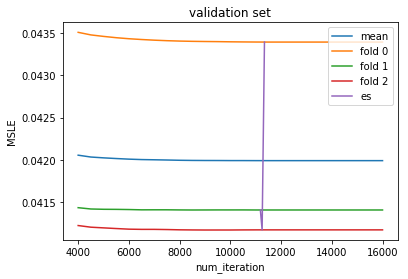

In [51]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['msle'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['msle'], label='fold '+str(i_fold))
plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['MSLE'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('MSLE')
plt.legend(); plt.title('validation set'); plt.show()

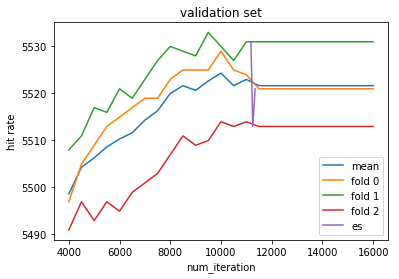

In [52]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['hit_rate'], label='fold '+str(i_fold))    
plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['hit_rate'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.legend(); plt.title('validation set'); plt.show()

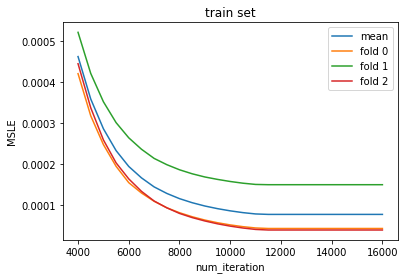

In [49]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['msle_train'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['msle_train'], label='fold '+str(i_fold))
#plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['MSLE'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('MSLE')
plt.legend(); plt.title('train set'); plt.show()

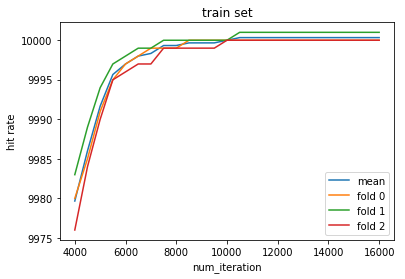

In [50]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate_train'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['hit_rate_train'], label='fold '+str(i_fold))    
#plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['hit_rate'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.legend(); plt.title('train set'); plt.show()

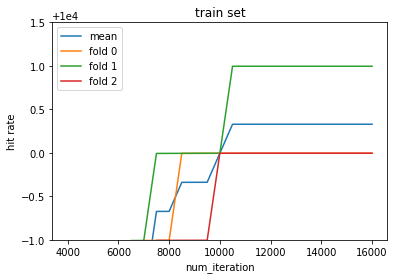

In [56]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate_train'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['hit_rate_train'], label='fold '+str(i_fold))    
#plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['hit_rate'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.ylim(9999, 10001.5)
plt.legend(); plt.title('train set'); plt.show()

In [34]:
def kfold_cv_iteration_evaluation(models, iter_min, iter_max, iter_step, results=[]):
    if iter_max > 
    iter_list = list(range(iter_min, iter_max+1, iter_step))
    
    print(iter_list)
    for i_fold, (df_train, df_val, model) in enumerate(zip(df_trains, df_vals, models)):
        print('==== Fold', i_fold+1, '====')
        
        for num_iteration in iter_list:
            result = {
                'i_fold': i_fold,
                'num_iteration': num_iteration,
            }
            
            # Validation set
            y_pred = model.predict(df_val[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_val, y_pred)
            result['msle'] = mean_squared_log_error(df_val['total_price'], y_pred_final)
            result['hit_rate'] = cal_score(df_val['total_price'], y_pred_final)
            
            # Train set
            y_pred = model.predict(df_train[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_train, y_pred)
            result['msle_train'] = mean_squared_log_error(df_train['total_price'], y_pred_final)
            result['hit_rate_train'] = cal_score(df_train['total_price'], y_pred_final)

            print(result)
            
            results.append(result)
        
    return results

### Conclusion

- Round 1 best params (random seed = 123):
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5)),  

Best scores: 5501.863278855861  
[5527.864888142274, 5498.864225711784, 5478.860722713526]

- Round 2 best params (random seed = 123):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Best scores: *5515.529915334645*  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

- Round 2 best params (random seed = 246):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0.1)  
   
Best scores: *5524.863045737181*  
[5528.862755759428, 5530.862894274216, 5514.863487177898]

### Other info

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()